# Notebook for MC results
1. generate MonteCarlo samples for the SK model
2. Train a sk1rsb net on the MC generated samples

In [1]:
import sys
import networkx as nx
import numpy as np
import random
from collections import defaultdict
import torch
import math
import importlib
import pandas as pd
#torch.set_num_threads(1)

sys.path.insert(0, '../../')
import python_lib.graph_gen as graph_gen
import python_lib.models as models
#from python_lib import solvers



In [2]:
%matplotlib inline

# Sherrington Kirkpatrick

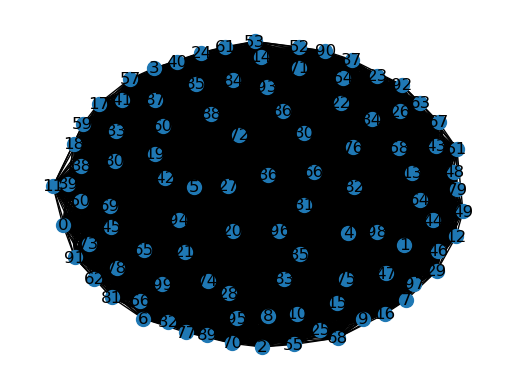

In [3]:
import importlib
import matplotlib.pyplot as plt
import random
seed=4

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
N = 100
fig, ax0 = plt.subplots(1,1)
J_interaction = torch.ones(N,N) - torch.eye(N, N)

inter_H = 0
H = inter_H * (torch.ones(N))
J_sigma_val=1
J_0_val=0
if N < 200:
    graph_gen.plot_matrix_graph(J_interaction, ax0)

J_prob = graph_gen.spin_glass(N, J = J_sigma_val, J_0 = J_0_val)
J = graph_gen.set_J(J_interaction, J_prob)
#J = (J + J.transpose())
#N_rand, J_interaction_rand = graph_gen.tree_interaction(Degree, Height, rand=True)

# Exact solutions
enumerating all configurations.
Th. results

In [4]:
from python_lib.models import spins_model
import python_lib.models
importlib.reload(spins_model)
from python_lib.models import spins_model

device="cpu"
SK_model = spins_model.model(N, H, J, J_interaction, device=device)
beta_fin=2
beta_init = 0.1
step = 39
betas = np.linspace(beta_init, beta_fin, step)

stats_step=1

In [5]:
from python_lib.models import spins_model
importlib.reload(spins_model)

SK_model_exact = spins_model.model(N, H, J, J_interaction, device=device)
f_exact = []
f_exact_infN = []
steps = 0
if N < 25:
    for beta_ in betas:
        if steps % stats_step == 0:
            f_exact.append(SK_model_exact.exact(beta_))
        steps += 1
else:
    print("sorry systems too bog for exact computation")


sorry systems too bog for exact computation


# MonteCarlo sampler

 999.0 / 1000tensor([98., 96., 94.,  ..., 14., 14., 14.])


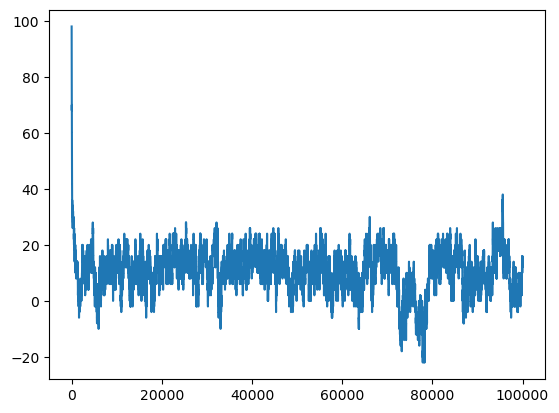

In [6]:
import torch
import numpy as np

# Define the number of spins
num_spins = N

# Define the interaction strength between the spins
#J = torch.randn((num_spins, num_spins))

# Define the external magnetic field strength
#h = torch.randn((num_spins))

# Define the temperature (beta)
beta = 2
J=torch.Tensor(J)
h=torch.Tensor(H)
# Define the initial state
initial_state = torch.randint(2, (num_spins,), dtype=J.dtype) * 2 - 1

# Define the number of MCMC steps
num_swap = 1000
num_steps = num_swap * N

# Define the current state
current_state = initial_state

# Define the time correlation array
time_correlation = torch.zeros((num_steps,))

all_states = torch.zeros((num_swap, num_spins))
initial_energy = -torch.dot(initial_state, torch.matmul(J, initial_state)) - torch.dot(initial_state, h)

# Loop over the number of MCMC steps
for i in range(num_steps):
    # Choose a random spin to flip
    flip_index = torch.randint(num_spins, (1,))
    proposal_state = current_state.clone().detach()
    proposal_state[flip_index] = -proposal_state[flip_index]

    # Calculate the energy difference between the proposal state and the current state
    energy_diff = -torch.dot(proposal_state, torch.matmul(J, proposal_state)) - torch.dot(proposal_state, h) + torch.dot(current_state, torch.matmul(J, current_state)) + torch.dot(current_state, h)

    #inter = -((samples @ self.J).view(m, 1, self.N) @ samples.view(m, self.N, 1)).squeeze()
    #field = -(samples.view(m, 1, self.N) @ self.H.view(self.N, 1)).squeeze()


    # Calculate the acceptance probability
    acceptance_prob = torch.min(torch.tensor([1.0]), torch.exp(-beta * energy_diff))

    # Generate a random number between 0 and 1
    random_number = torch.rand(1)

    # Decide whether to accept or reject the proposal state
    if random_number < acceptance_prob:
        current_state = proposal_state
    else:
        current_state = current_state

    # Compute the time correlation
    time_correlation[i] = torch.dot(current_state, initial_state)
    
    if i % N == 0:
        all_states[int(i/N)] = current_state
        print(f"\r {i/N} / {num_swap}", end="")
# Print the time correlation array
print(time_correlation)
import matplotlib.pyplot as plt
plt.plot(time_correlation)


In [7]:
num_taus = 200
time_correlation = torch.zeros((num_taus,))
for taus in range(1, num_taus):
    print(f"\r {taus} / {num_taus}", end="")
    norm_T=0
    for i in range(num_swap):
        if i + taus < num_swap:
            time_correlation[taus] += torch.dot(all_states[i], all_states[i+taus])
            norm_T += 1
        else:
            time_correlation[taus] /= (norm_T*N)
            break

 199 / 200

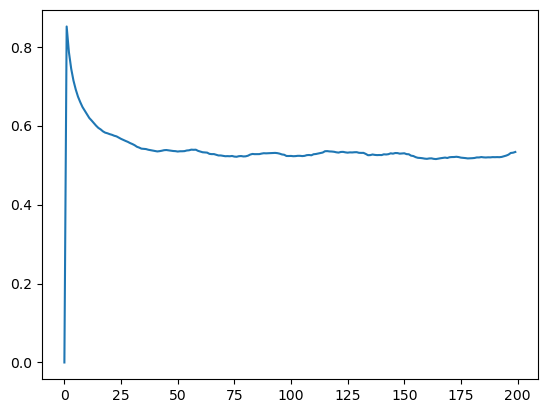

In [8]:
import matplotlib.pyplot as plt
plt.plot(time_correlation)

In [9]:
import torch
import numpy as np

# Define the number of spins
num_spins = N

# Define the interaction strength between the spins
#J = torch.randn((num_spins, num_spins))

# Define the external magnetic field strength
#h = torch.randn((num_spins))

# Define the temperature (beta)
beta = 2
J=torch.Tensor(J)
h=torch.Tensor(H)
# Define the initial state
m = 200
num_sample=10000
sample_every_swap=200
num_swap = sample_every_swap * num_sample / m
initial_state = torch.randint(2, (m, num_spins), dtype=J.dtype) * 2 - 1


# Define the number of MCMC steps
num_steps = num_swap * N

# Define the current state
current_state = initial_state

# Define the time correlation array
#time_correlation = torch.zeros((num_steps,))

all_states = torch.zeros((int(num_sample/m),m, num_spins))

# Loop over the number of MCMC steps
for swap_ in range(int(num_swap)):
    for i in range(N):
    # Choose a random spin to flip
        flip_index = torch.randint(num_spins, (m,))
        proposal_state = current_state.clone().detach()
        proposal_state[:,flip_index] = -proposal_state[:,flip_index]

        # Calculate the energy difference between the proposal state and the current state
        inter_curr = -(
                (current_state @ J).view(m, 1, N) @ current_state.view(m, N, 1)
            ).squeeze()
        field_curr = -(current_state.view(m, 1, N) @
                    H.view(N, 1)).squeeze()
        inter_prop = -(
                (proposal_state @ J).view(m, 1, N) @ proposal_state.view(m, N, 1)
            ).squeeze()
        field_prop = -(proposal_state.view(m, 1, N) @
                    H.view(N, 1)).squeeze()

        energy_diff = - inter_curr + field_curr + (inter_prop + field_prop)

        #inter = -((samples @ self.J).view(m, 1, self.N) @ samples.view(m, self.N, 1)).squeeze()
        #field = -(samples.view(m, 1, self.N) @ self.H.view(self.N, 1)).squeeze()


        # Calculate the acceptance probability
        acceptance_prob = torch.min(torch.tensor(m*[1.0]), torch.exp(-beta * energy_diff))

        # Generate a random number between 0 and 1
        random_number = torch.rand(m)

        # Decide whether to accept or reject the proposal state
        current_state = torch.where((random_number < acceptance_prob).unsqueeze(dim=1), proposal_state, current_state)

        # Compute the time correlation
        #time_correlation[i] = torch.dot(current_state, initial_state)
        
    if swap_ % sample_every_swap == 0:
        all_states[int(swap_/sample_every_swap)] = current_state
    print(f"\r {swap_} / {num_swap}", end="")
# Print the time correlation array
#print(time_correlation)
#import matplotlib.pyplot as plt
#plt.plot(time_correlation)


 9999 / 10000.0

In [10]:
all_states.mean()

tensor(-0.0033)

# Train net

In [11]:
import python_lib.nets.ann
importlib.reload(python_lib.nets.ann)

from python_lib.nets import h2arnn
importlib.reload(h2arnn)
from python_lib import run_lib
importlib.reload(run_lib);

In [12]:
lr = 0.001
max_step = 1000
batch_size=2000
std_fe_limit=1e-4
batch_iter=20
stats_step=1
batch_fraction=2

In [13]:
J_not = graph_gen.set_J(J_interaction, J_prob)
J_not = J_not/np.sqrt(N)
SK_model_not = spins_model.model(N, H, J_not, J_interaction, device=device)



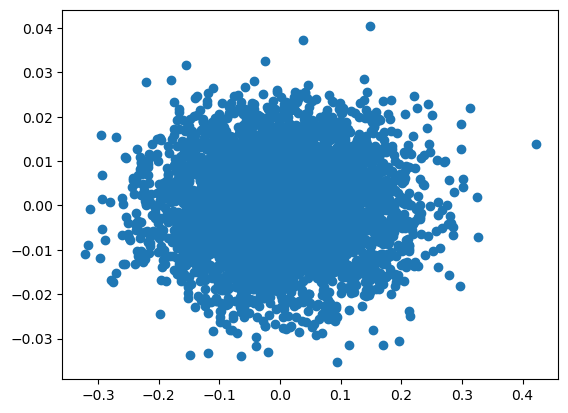

In [14]:
plt.plot(J.detach().cpu().numpy().flatten(), SK_model_not.J.cpu().flatten(), "o")

In [15]:
rho = h2arnn.SK_krsb
learn = True
dict_nets = {"k": 1, "set_exact": learn}
input_mask = torch.tril(J_interaction, diagonal=-1)
input_mask = input_mask.to(dtype=torch.bool)
net = h2arnn.h2arnn(
    SK_model, rho, input_mask, device=device, dict_nets=dict_nets, learn_first_l=learn)
net.set_params_first_l(SK_model_not)

Total Trainable Params: 59700
Total Params: 59700


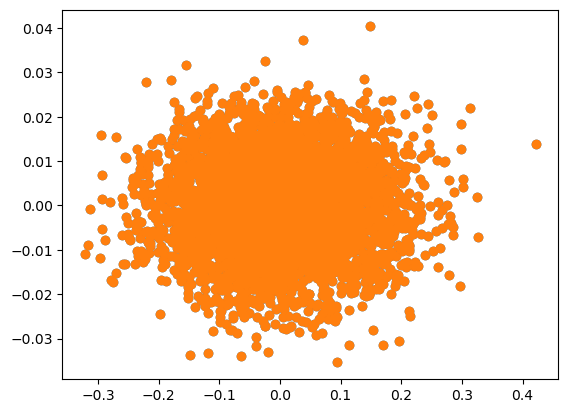

In [16]:
plt.plot(J.detach().cpu().numpy().flatten(), net.J.detach().cpu().numpy().flatten(), "o")
plt.plot(J.detach().cpu().numpy().flatten(), J_not.flatten(), "o")

In [17]:
samples = all_states.view(-1, N)

In [18]:
samples = samples.to(device=device)

In [19]:
import matplotlib.pyplot as plt

stats = net.train_with_samples(
                            samples,
                            lr=lr,
                            max_step=100,
                            std_fe_limit=std_fe_limit,
                            batch_iter=batch_iter,
                            beta=beta,
                            batch_fraction=batch_fraction,
                            )
plt.plot(J.detach().cpu().numpy().flatten(), net.J.detach().cpu().numpy().flatten(), "o")

plt.plot(J.detach().cpu().numpy().flatten(), J_not.flatten(), "o")

step: 62 2.00000 fe: -0.353 +- 0.07014 E: -0.007, S: 0.693, M: 0.0784 sample_t : 0.0 log_prob : 0.54 loss : 0.91 optimizer : 0.52 stats : 0.1950955

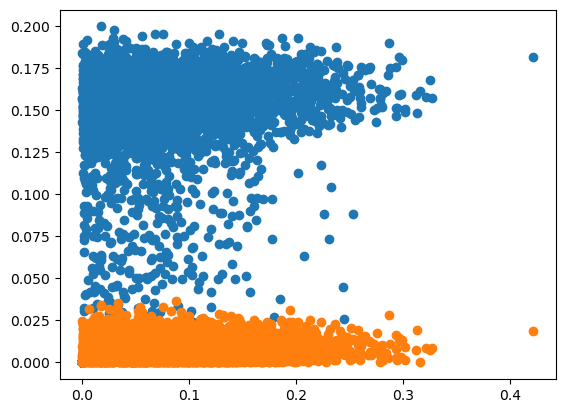

In [ ]:
import matplotlib.pyplot as plt
plt.plot(np.abs(J.detach().cpu().numpy().flatten()), np.abs(net.J.detach().numpy().flatten()), "o")

plt.plot(np.abs(J.detach().cpu().numpy().flatten()), np.abs(J_not.flatten()), "o")

step: 319 2.00000 fe: -0.662 +- 0.04576 E: -0.438, S: 0.448, M: 0.0968 sample_t : 1.2e-06 log_prob : 0.7 loss : 1.3 optimizer : 0.66 stats : 0.1227

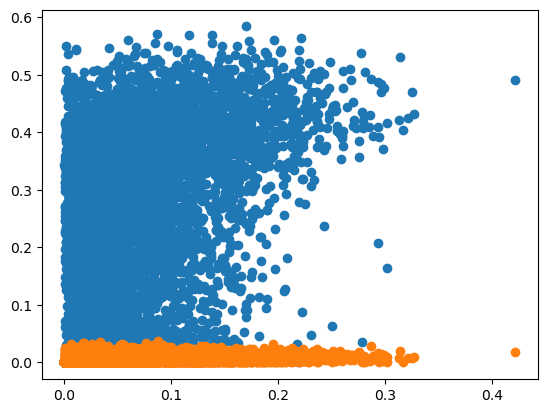

In [ ]:
stats = net.train_with_samples(
                            samples,
                            lr=lr,
                            max_step=300,
                            batch_fraction=batch_fraction,
                            std_fe_limit=std_fe_limit,
                            batch_iter=batch_iter,
                            beta=beta
                            )
import matplotlib.pyplot as plt
plt.plot(np.abs(J.detach().cpu().numpy().flatten()), np.abs(net.J.detach().numpy().flatten()), "o")

plt.plot(np.abs(J.detach().cpu().numpy().flatten()), np.abs(J_not.flatten()), "o")

step: 1019 2.00000 fe: -0.710 +- 0.02474 E: -0.538, S: 0.345, M: 0.0979 sample_t : 0.0 log_prob : 0.68 loss : 1.1 optimizer : 0.56 stats : 0.1 0.199

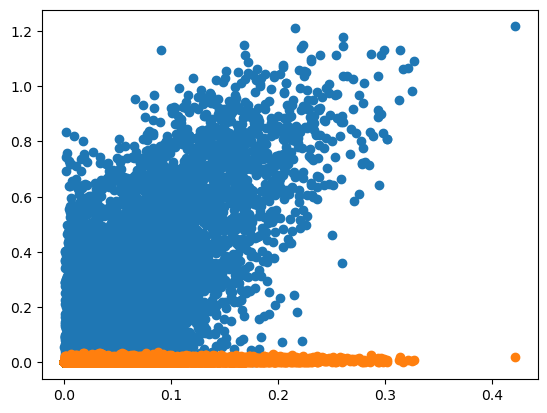

In [ ]:
stats = net.train_with_samples(
                            samples,
                            lr=lr,
                            max_step=1000,
                            batch_fraction=batch_fraction,
                            std_fe_limit=std_fe_limit,
                            batch_iter=batch_iter,
                            beta=beta
                            )
import matplotlib.pyplot as plt
plt.plot(np.abs(J.detach().cpu().numpy().flatten()), np.abs(net.J.detach().numpy().flatten()), "o")

plt.plot(np.abs(J.detach().cpu().numpy().flatten()), np.abs(J_not.flatten()), "o")

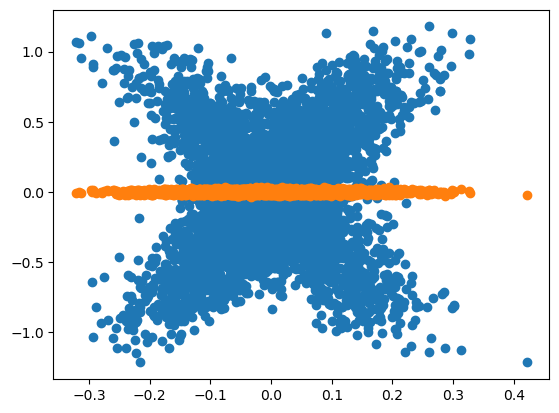

In [ ]:
import matplotlib.pyplot as plt
plt.plot(J.detach().numpy().flatten(), net.J.detach().numpy().flatten(), "o")

plt.plot(J.detach().numpy().flatten(), J_not.flatten(), "o")

[0.03908757 3.64293473]
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.644
Model:                            OLS   Adj. R-squared:                  0.644
Method:                 Least Squares   F-statistic:                 1.809e+04
Date:                Wed, 08 Feb 2023   Prob (F-statistic):               0.00
Time:                        11:46:47   Log-Likelihood:                 4501.4
No. Observations:               10000   AIC:                            -8999.
Df Residuals:                    9998   BIC:                            -8984.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0391      0

<AxesSubplot:>

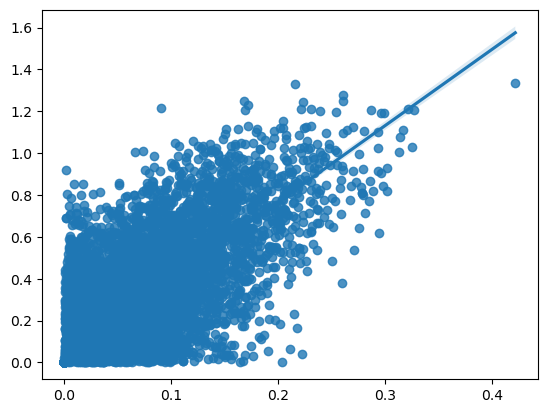

In [ ]:
import seaborn as sns
import statsmodels.api as sm

y = np.abs(net.J.detach().numpy().flatten())
x = np.abs(J.detach().numpy().flatten())

model = sm.OLS(y, sm.add_constant(x))
results = model.fit()

print(results.params)
# const        10.603498 <- intercept
# education     0.594859 <- slope
# dtype: float64

print(results.summary())
sns.regplot(x=x, y=y)


<AxesSubplot:>

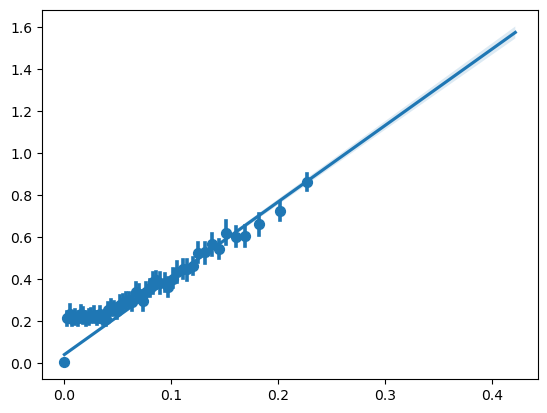

In [ ]:
sns.regplot(x=x, y=y, x_bins=100)


In [ ]:
np.savez("MC_data/data.npz", J=J.detach().numpy(), J_not=J_not, net=net.J.detach().numpy(), samples=samples, lr=lr, max_step=max_step, batch_fraction=batch_fraction, std_fe_limit=std_fe_limit, batch_iter=batch_iter, beta=beta)